In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install torch

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 750.6 MB 2.3 kB/s  eta 0:00:01    |██                              | 48.3 MB 25.6 MB/s eta 0:00:28     |████████▉                       | 206.7 MB 24.1 MB/s eta 0:00:23██████▉                      | 230.7 MB 24.1 MB/s eta 0:00:22     |███████████▏                    | 262.6 MB 45.6 MB/s eta 0:00:11     |████████████▉                   | 300.1 MB 50.7 MB/s eta 0:00:09     |██████████████████▉             | 442.1 MB 43.2 MB/s eta 0:00:08     |████████████████████████        | 561.8 MB 44.7 MB/s eta 0:00:05     |████████████████████████████▌   | 668.9 MB 40.1 MB/s 

In [4]:
# importing required libraries 

import pandas as pd
import numpy as np
# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# CountVectorizer for Bagof words model
from sklearn.feature_extraction.text import CountVectorizer

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

# MODEL1

In [6]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        
        # BOW 
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.review.tolist())
        
        # Creating Vocabulary
        self.token2idx = vectorizer.vocabulary_
        
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [7]:
data  = pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')
data['label'] = data['sentiment']
del data['sentiment']
data.head()

,review,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
labeling = {'positive':1, 'negative':0}
data['label'] = data['label'].apply(lambda x : labeling[x])
data.shape

(50000, 2)

In [9]:
# feeding data in class and getting its instance in return 
dataset = Sequences(data, max_seq_len=128)
len(dataset.token2idx)

1046

In [10]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 2048
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

In [11]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cpu'
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self ):
        
        return (torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device),
                torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device) )
       
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        #o
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [12]:
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    batch_size=batch_size
)
model

RNN(
  (encoder): Embedding(1046, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [14]:
model.train()
train_losses = []
for epoch in range(5):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs, target
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/tmp/ipykernel_2752/1261787504.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.686


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.610


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.573


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.527


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.479


In [15]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))])
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [16]:
text= "that's nice"
predict_sentiment(text)

0.703: Positive sentiment


In [17]:
text = """I love this car.
This view is amazing.
I feel great this morning.
I am so excited about the concert.
He is my best friend
"""
predict_sentiment(text)

0.796: Positive sentiment


In [18]:
text="""
I do not like this car.
This view is horrible.
I feel tired this morning.
I am not looking forward to the concert.
He is my enemy
"""
predict_sentiment(text)

0.317: Negative sentiment


# MODEL2

In [20]:
data=pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')

In [21]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [22]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Generating word frequencies

In [23]:
def gen_freq(text):
    #will store all the words in list
    words_list = []
    
    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
    
    #print top 100 words
    word_freq[:100]
    
    return word_freq  

In [24]:
freq = gen_freq(data.review.str)
freq

the                568735
a                  306960
and                301919
of                 283625
to                 261850
                    ...  
"Mithi/Mithali"         1
(Konkona)               1
"Prof.Anu"              1
(Shabhana               1
Yosemite.<br            1
Length: 438729, dtype: int64

# Word cloud

In [26]:
pip install wordcloud

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 371 kB 24.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


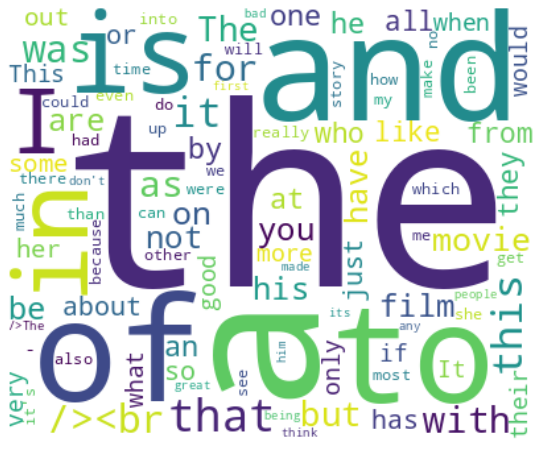

In [27]:
#Import library WordCloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Positive word cloud

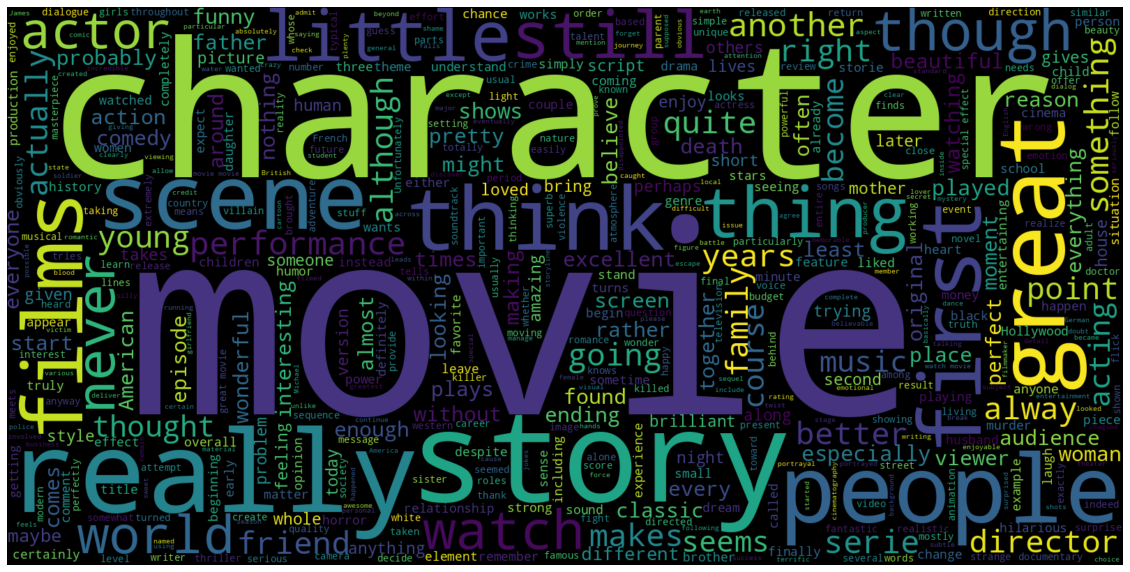

In [28]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Negative word cloud

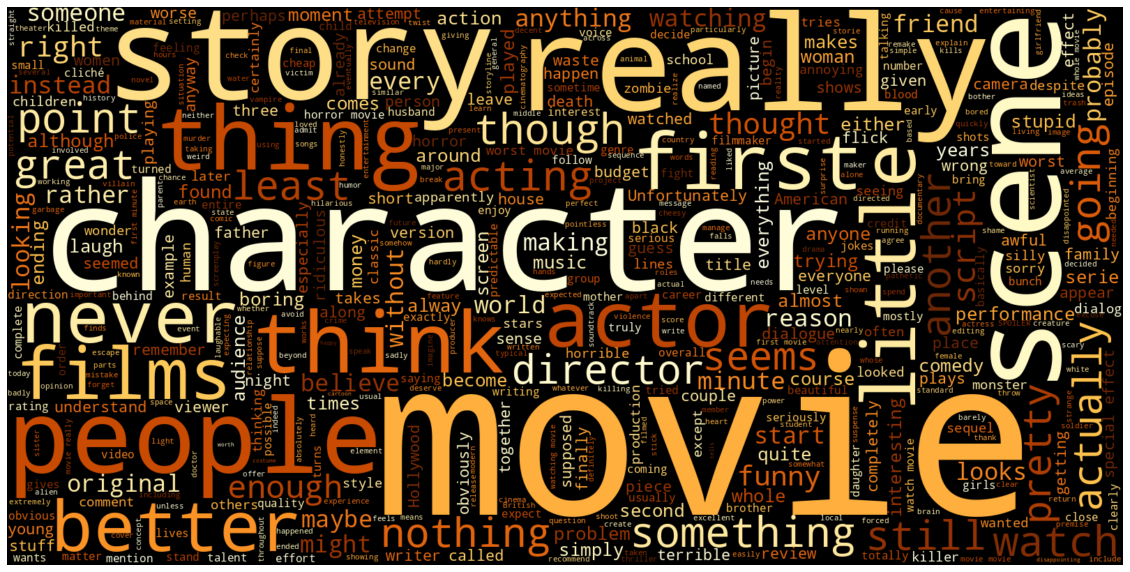

In [29]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Removing stop words

In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [33]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer()

In [34]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['review']= data['review'].apply(remove_stopwords)

In [35]:
import re
#clearing punctuation & unnecessary marks
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
data['review'] = data['review'].apply(lambda x: x.lower())

#cleaning extra spaces
data['review'] = data['review'].apply(lambda x: x.strip())

In [36]:
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    return text

#Apply function on review column
    text = strip_html(text)
    text = remove_between_square_brackets(text)
data['review']=data['review'].apply(denoise_text)
data_copy = data.copy()

# Word clouds after text cleaning

In [37]:
data.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ...,1
1,wonderful little production br br the ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks ...,0
4,petter mattei love time money visually stu...,1


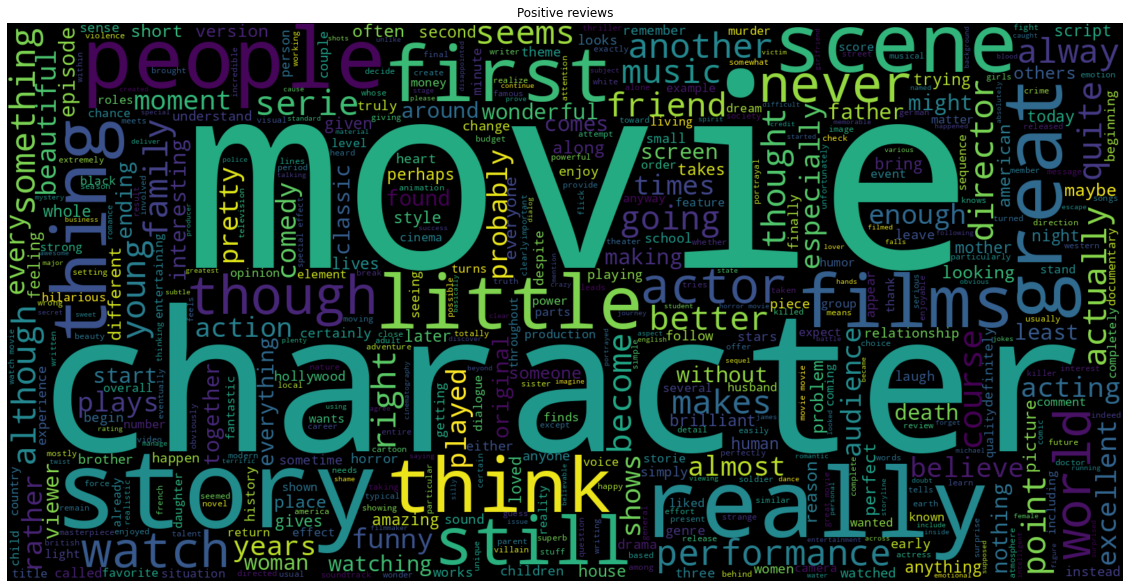

In [38]:
# POSITIVE REVIEWS
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.title('Positive reviews')
plt.imshow(Wc , interpolation = 'bilinear')

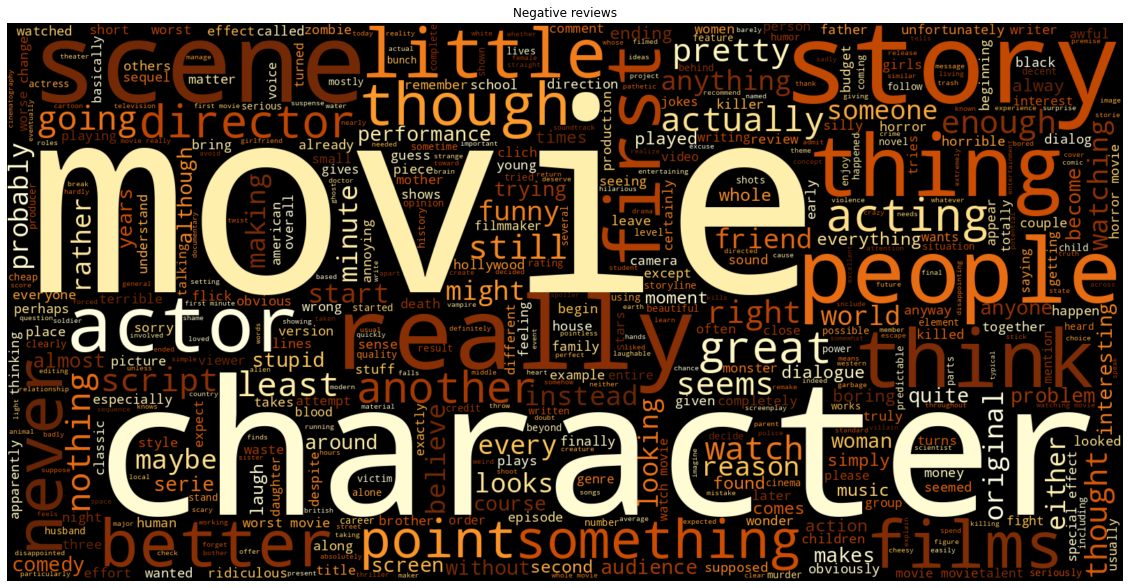

In [39]:
# Negative Reviews
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.title('Negative reviews')
plt.imshow(Wc , interpolation = 'bilinear')

# Test-train split

In [40]:
sentiment = data['sentiment'].values
data = data['review']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

# Dictionary

In [42]:
#from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)
#tokenizer.word_index

In [43]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [44]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

292

In [45]:
#percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9454

In [46]:
import keras
#data is adjusted according to the number of tokens specified
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_tokens, maxlen=max_tokens)
x_train_pad.shape

(40000, 292)

In [47]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [48]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

2022-04-09 14:44:18.593003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-09 14:44:18.593097: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 14:44:18.593161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AB1208SCOPE66): /proc/driver/nvidia/version does not exist
2022-04-09 14:44:18.603154: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 292, 50)          750000    
                                                                 
 lstm (LSTM)                 (None, 292, 16)           4288      
                                                                 
 dropout (Dropout)           (None, 292, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 292, 8)            800       
                                                                 
 dropout_1 (Dropout)         (None, 292, 8)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

In [50]:
history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Epoch 1/5


2022-04-09 14:44:28.036688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58400000 exceeds 10% of free system memory.
2022-04-09 14:44:28.150053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58400000 exceeds 10% of free system memory.


 1/28 [>.............................] - ETA: 2:18 - loss: 0.6932 - accuracy: 0.4750

2022-04-09 14:44:29.723969: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58400000 exceeds 10% of free system memory.
2022-04-09 14:44:29.738128: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58400000 exceeds 10% of free system memory.
2022-04-09 14:44:29.916586: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58400000 exceeds 10% of free system memory.


28/28 [==============================] - 30s 938ms/step - loss: 0.6828 - accuracy: 0.6048 - val_loss: 0.6483 - val_accuracy: 0.7480
Epoch 2/5
28/28 [==============================] - 25s 885ms/step - loss: 0.5381 - accuracy: 0.8214 - val_loss: 0.4689 - val_accuracy: 0.8443
Epoch 3/5
28/28 [==============================] - 25s 885ms/step - loss: 0.4140 - accuracy: 0.8899 - val_loss: 0.4187 - val_accuracy: 0.8648
Epoch 4/5
28/28 [==============================] - 24s 866ms/step - loss: 0.3493 - accuracy: 0.9200 - val_loss: 0.3949 - val_accuracy: 0.8631
Epoch 5/5
28/28 [==============================] - 26s 920ms/step - loss: 0.3021 - accuracy: 0.9350 - val_loss: 0.3732 - val_accuracy: 0.8670


In [51]:
result = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 15s 46ms/step - loss: 0.3720 - accuracy: 0.8670


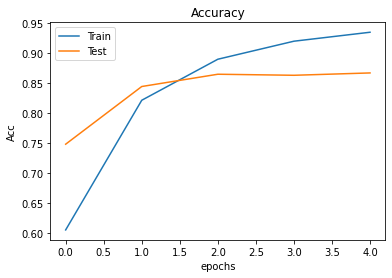

In [52]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

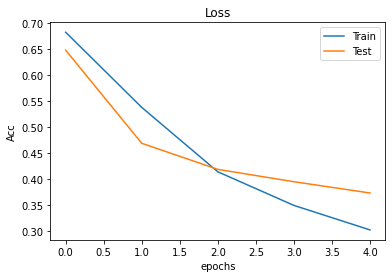

In [53]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [54]:
df=pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')
df['sentiment'] = np.where(df['sentiment'] == 'positive', 1, 0)
df=pd.DataFrame(df['sentiment'])
df

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [55]:
pd.DataFrame(data)

,review
0,one reviewers mentioned watching oz episode ...
1,wonderful little production br br the ...
2,thought wonderful way spend time hot summer we...
3,basically family little boy jake thinks ...
4,petter mattei love time money visually stu...
...,...
49995,thought movie right good job creative origin...
49996,bad plot bad dialogue bad acting idiotic di...
49997,catholic taught parochial elementary schools n...
49998,going disagree previous comment side maltin on...


In [56]:
data.to_csv('Optimized.csv')

data=pd.DataFrame(data,df)
data

In [57]:
df=data
df.head()

0    one reviewers mentioned watching   oz episode ...
1    wonderful little production  br     br    the ...
2    thought wonderful way spend time hot summer we...
3    basically   family little boy  jake  thinks   ...
4    petter mattei    love time money  visually stu...
Name: review, dtype: object

import spacy
spacy.load('en_core_web_sm')
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd

data.columns = ['TEXT_COLUMN_NAME', 'LABEL_COLUMN_NAME']

RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

# Define feature processing
TEXT = torchtext.legacy.data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm')
# Define Label processing

LABEL = torchtext.legacy.data.LabelField(dtype = torch.long)
data.to_csv('moviedata.csv', index = None)
data = pd.read_csv('moviedata.csv')
data.head()

fields = [('review', TEXT), ('sentiment', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
                    path = 'moviedata.csv',
                    format = 'csv',
                    skip_header = True,
                    fields = fields)

train_data, test_data = dataset.split(split_ratio = [0.8, 0.2], random_state = random.seed(RANDOM_SEED))

print('Length of train data', len(train_data))
print('Length of test data', len(test_data))

train_data, val_data = train_data.split(split_ratio = [0.85, 0.15], random_state = random.seed(RANDOM_SEED))

print('Length of train data', len(train_data))
print('Length of valid data', len(val_data))

# Tokenization

print(vars(train_data.examples[2000]))

# Build Vocabulary

TEXT.build_vocab(train_data, max_size = VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'vocabulary size: {len(TEXT.vocab)}')
print(f'Label Size: {len(LABEL.vocab)}')

#common words
print(TEXT.vocab.freqs.most_common(30))

# Token corresponding to first 10 Indices

print(TEXT.vocab.itos[:20]) #itos = Integer to string

print(TEXT.vocab.stoi['top'])

# class labels to Integer from string

print(LABEL.vocab.stoi)

LABEL.vocab.freqs

# Define Dataloader

train_loader, valid_loader, test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, val_data, test_data),
        batch_size = BATCH_SIZE,
        sort_within_batch = False,
        sort_key = lambda x : len(x.review),
        #device = DEVICE
    )
# Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.review.size()}')
    print(f'Target vector size: {batch.sentiment.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.review.size()}')
    print(f'Target vector size: {batch.sentiment.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.review.size()}')
    print(f'Target vector size: {batch.sentiment.size()}')
    break

train_loader, valid_loader, test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, val_data, test_data),
        batch_size = BATCH_SIZE,
        sort_within_batch = False,
        sort_key = lambda x : len(x.review))

class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Accuracy

def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.TEXT_COLUMN_NAME.to(DEVICE)
        labels = batch_data.LABEL_COLUMN_NAME.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

import spacy


nlp = spacy.blank("en")

def predict_sentiment(model, sentence):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][1].item()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")

print('Probability positive:')
predict_sentiment(model, "I really hate this movie. It is really bad and sucks!")

In [59]:
data.columns = ['review', 'sentiment']
data.head()

0    one reviewers mentioned watching   oz episode ...
1    wonderful little production  br     br    the ...
2    thought wonderful way spend time hot summer we...
3    basically   family little boy  jake  thinks   ...
4    petter mattei    love time money  visually stu...
Name: review, dtype: object

In [60]:
data.to_csv('Optimized.csv')

In [62]:
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english')) #declaring stop words

def load_dataset():
    df = pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
45760    [i, disliked, movie, numerous, reasons, within...
5919     [i, believe, many, people, hate, hal, sparks, ...
45922    [peeew, stinks, as, everyone, knows, based, up...
7817     [university, professor, justin, thorne, jimmy,...
43992    [i, barely, made, one, episode, crouch, end, t...
                               ...                        
11036    [this, meant, comedy, mainly, bad, taste, noth...
35020    [i, thought, movie, watched, pluto, nash, movi...
21417    [bergman, comedy, quite, go, together, some, c...
41824    [i, watched, short, planetout, movies, starcro...
32697    [i, went, movie, knowing, nothing, ended, real...
Name: review, Length: 35000, dtype: object 

21950    [it, came, ten, commandments, land, pharaohs, ...
49215    [there, doubt, decade, names, boris, karloff, ...
17154    [glorifying, glamorizing, world, war, ii, we, ...
18748    [this, one, military, drama, i, like, lot, tom...
45560    [hitting, ground, running, film, begins, three...
 

In [64]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    1  4896     3 ...    64  5286  2308]
 [    1   167    36 ...   421   218  4810]
 [54074  4603   112 ...    10   152     2]
 ...
 [ 3052   113    92 ...     0     0     0]
 [    1   192   241 ...     0     0     0]
 [    1   323     3 ...     0     0     0]] 

Encoded X Test
 [[    7   289   609 ...   738 50555    50]
 [   50   698  2124 ...  2738 85832  1702]
 [17816 44943    85 ...  2831   542     4]
 ...
 [   49   411    85 ...     0     0     0]
 [   10  2009   435 ...     0     0     0]
 [  316  1571  5633 ...     0     0     0]] 

Maximum review length:  130


In [66]:
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model
# LSTM Model
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2795456   
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,820,353
Trainable params: 2,820,353
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Final evaluation of the model

model.fit(x_train, y_train, batch_size = 256, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
137/137 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.6209
Epoch 1: accuracy improved from -inf to 0.62086, saving model to models/LSTM.h5
137/137 [==============================] - 26s 176ms/step - loss: 0.6138 - accuracy: 0.6209
Epoch 2/5
137/137 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8982
Epoch 2: accuracy improved from 0.62086 to 0.89817, saving model to models/LSTM.h5
137/137 [==============================] - 23s 170ms/step - loss: 0.2682 - accuracy: 0.8982
Epoch 3/5
137/137 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9558
Epoch 3: accuracy improved from 0.89817 to 0.95580, saving model to models/LSTM.h5
137/137 [==============================] - 23s 170ms/step - loss: 0.1366 - accuracy: 0.9558
Epoch 4/5
137/137 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9787
Epoch 4: accuracy improved from 0.95580 to 0.97874, saving model to models/LSTM.h5
137/137 [======

In [68]:
y_pred = model.predict(x_test, batch_size = 128)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 0
Wrong Prediction: 15000
Accuracy: 0.0


In [69]:
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import collections
import itertools

In [71]:
df=pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))
df

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is a...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6249
           1       0.89      0.91      0.90      6251

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



<AxesSubplot:>

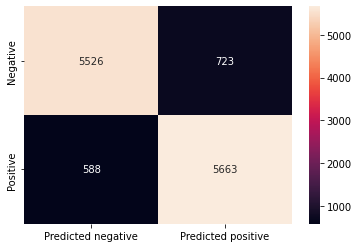

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# LSTM for 500 characters

In [73]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to love this was the most i d laugh'

# Tokenize and padding

In [74]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 9999


In [75]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 116) (8000, 116) (10000, 116) (32000,) (8000,) (10000,)


In [76]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [77]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1000/1000 [==============================] - 67s 64ms/step - loss: 0.4733 - accuracy: 0.7706 - val_loss: 0.4318 - val_accuracy: 0.8270
Epoch 2/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3244 - accuracy: 0.8652 - val_loss: 0.3825 - val_accuracy: 0.8292
Epoch 3/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.2496 - accuracy: 0.8997 - val_loss: 0.4590 - val_accuracy: 0.8285
Epoch 4/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.1829 - accuracy: 0.9285 - val_loss: 0.4421 - val_accuracy: 0.8240
Epoch 5/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.1413 - accuracy: 0.9479 - val_loss: 0.5349 - val_accuracy: 0.8092


<AxesSubplot:>

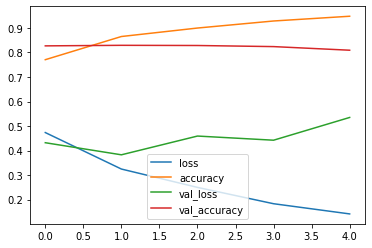

In [78]:
pd.DataFrame(history.history).plot()

y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Dropout layers to prevent overfitting

In [80]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 64)         0         
 ropout1D)                                                       
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [81]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
500/500 [==============================] - 56s 110ms/step - loss: 0.6434 - accuracy: 0.6024 - val_loss: 0.5016 - val_accuracy: 0.7738
Epoch 2/20
500/500 [==============================] - 58s 117ms/step - loss: 0.4476 - accuracy: 0.8011 - val_loss: 0.4053 - val_accuracy: 0.8198
Epoch 3/20
500/500 [==============================] - 55s 111ms/step - loss: 0.3694 - accuracy: 0.8423 - val_loss: 0.3842 - val_accuracy: 0.8298
Epoch 4/20
500/500 [==============================] - 55s 111ms/step - loss: 0.3343 - accuracy: 0.8588 - val_loss: 0.3788 - val_accuracy: 0.8311
Epoch 5/20
500/500 [==============================] - 63s 126ms/step - loss: 0.3092 - accuracy: 0.8712 - val_loss: 0.3771 - val_accuracy: 0.8335
Epoch 6/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2915 - accuracy: 0.8798 - val_loss: 0.3929 - val_accuracy: 0.8329
Epoch 7/20
500/500 [==============================] - 62s 125ms/step - loss: 0.2770 - accuracy: 0.8874 - val_loss: 0.3936 - val_ac

<AxesSubplot:>

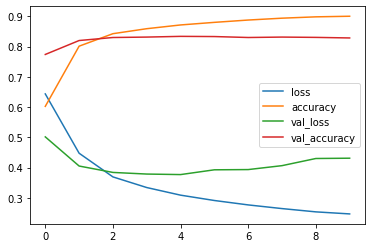

In [82]:
pd.DataFrame(history.history).plot()

In [84]:
data=pd.read_csv('/home/student/Downloads/IMDB Dataset.csv')

In [93]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [96]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/student/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [97]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
#from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers

In [99]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text
data_copy = data.copy()
data['review']=data['review'].apply(clean_text,lemmatize = True)
#converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]
#after converting labels
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


In [100]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [101]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,101366
1,film,91761
2,one,53928
3,like,40082
4,time,30344
5,would,30285
6,good,29108
7,character,28035
8,story,24760
9,even,24642


In [102]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

In [103]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

# LSTM

In [104]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  126241


In [105]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [106]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [107]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.53 % of data


In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 293)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 293, 64)           8079488   
                                                                 
 batch_normalization (BatchN  (None, 293, 64)          256       
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 293, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 289, 32)           10272     
                                                                 
 dropout_4 (Dropout)         (None, 289, 32)           0         
                                  

In [ ]:
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
#Data Processing — convert to lower case, Remove punctuation etc
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

In [ ]:
#Tokenize
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

In [ ]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)

print(reviews_int[:1])
df['Review int'] = reviews_int

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

In [ ]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
df.head()

# Padding/truncating

In [ ]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features
features = Padding(reviews_int, 200)
print(features[0, :])

In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

In [ ]:
class sentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        #sigmoid function
        sig_out = self.sigmoid(out)
        
        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [ ]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 2
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels 
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
            
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    output, test_h = model(inputs, test_h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import GRU
embedding_vecor_length = 50
max_review_length = 1000
NUM_WORDS = 10000

model = Sequential()
model.add(Embedding(NUM_WORDS, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics='accuracy')
model.summary()

In [ ]:
model.fit(X_train,y_train,epochs=5,batch_size=100,validation_data = (X_test,y_test),shuffle=True)

In [ ]:
print("Accuracy: ", np.round(model.evaluate(xte3,yte,verbose=0)[1]*100,3),"%")